In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
# from keras import utils
# from keras.callbacks import ReduceLROnPlateau, EarlyStopping


# Keras (via TensorFlow)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D,LSTM

# from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping




# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"


<>:7: SyntaxWarning: invalid escape sequence '\S'
<>:7: SyntaxWarning: invalid escape sequence '\S'
/var/folders/8b/_wrd0j755cj_xgf04tprxq000000gn/T/ipykernel_25401/2591407858.py:7: SyntaxWarning: invalid escape sequence '\S'
  TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


In [3]:
df = pd.read_csv("data/tweets_data.csv", encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [4]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [5]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
# Filtrer les tweets positifs, négatifs et neutres
positifs = df.loc[df['target'] == 4]
negatifs = df.loc[df['target'] == 0]


# Vérifier le nombre de tweets dans chaque catégorie
print(f"Nombre de tweets positifs : {len(positifs)}")
print(f"Nombre de tweets négatifs : {len(negatifs)}")

# Déterminer la taille d'échantillon disponible pour chaque catégorie
taille_echantillon = 50000

# Prendre l'échantillon si suffisamment de données sont disponibles
if taille_echantillon > 0:
    echantillon_positifs = positifs.sample(taille_echantillon)
    echantillon_negatifs = negatifs.sample(taille_echantillon)

    # Combiner les trois échantillons
    df = pd.concat([echantillon_positifs, echantillon_negatifs])

    # Afficher l'échantillon
    print(df)
else:
    print("Pas assez de tweets positifs, négatifs ou neutres disponibles pour créer un échantillon.")

Nombre de tweets positifs : 800000
Nombre de tweets négatifs : 800000
         target         ids                          date      flag  \
1520565       4  2176218858  Mon Jun 15 03:15:25 PDT 2009  NO_QUERY   
1196351       4  1984781209  Sun May 31 15:47:46 PDT 2009  NO_QUERY   
1024288       4  1883203644  Fri May 22 08:10:30 PDT 2009  NO_QUERY   
1071610       4  1966357573  Fri May 29 17:37:07 PDT 2009  NO_QUERY   
944880        4  1795854860  Thu May 14 08:28:58 PDT 2009  NO_QUERY   
...         ...         ...                           ...       ...   
38269         0  1573224495  Tue Apr 21 00:13:24 PDT 2009  NO_QUERY   
750658        0  2285738199  Mon Jun 22 15:30:58 PDT 2009  NO_QUERY   
316006        0  2002315311  Tue Jun 02 03:51:01 PDT 2009  NO_QUERY   
766801        0  2300103415  Tue Jun 23 13:44:12 PDT 2009  NO_QUERY   
248405        0  1982702969  Sun May 31 11:44:08 PDT 2009  NO_QUERY   

                   user                                               text  


In [7]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 11.8 ms, sys: 1.42 ms, total: 13.2 ms
Wall time: 12.7 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

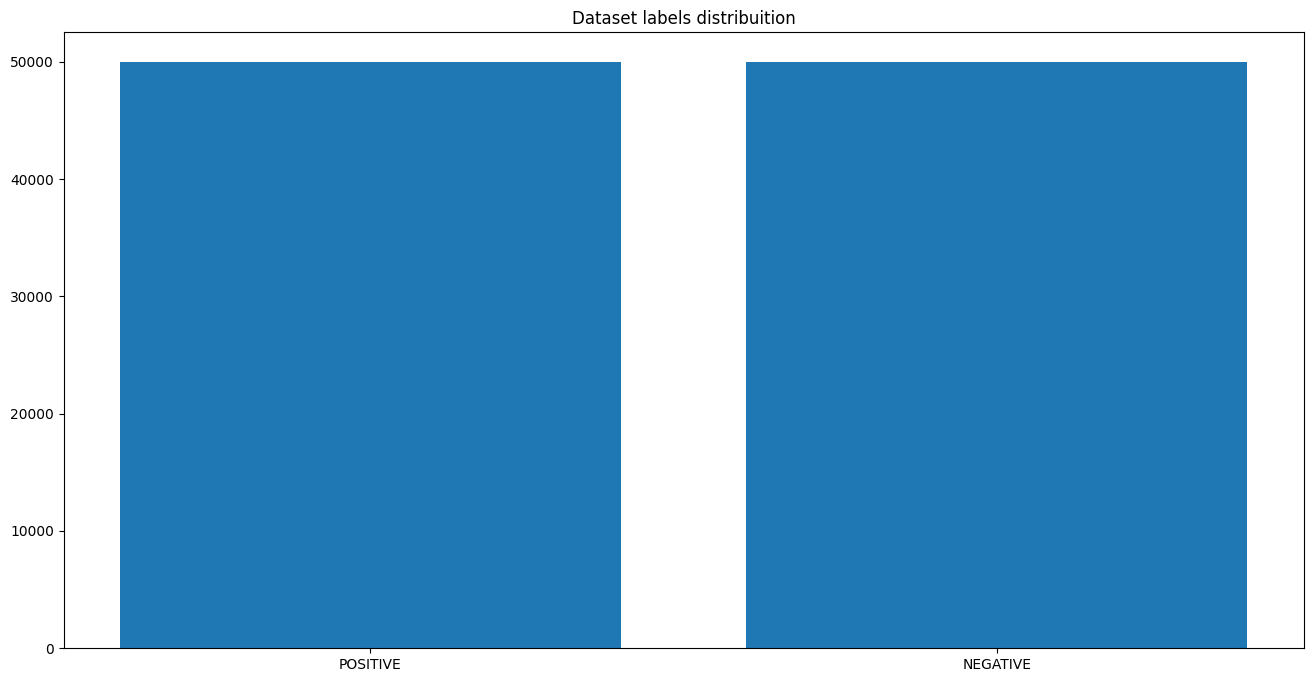

In [9]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [10]:
# nltk
import nltk

# Download the stopwords corpus
nltk.download('stopwords')

from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /Users/Apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [12]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 1.53 s, sys: 8.78 ms, total: 1.54 s
Wall time: 1.54 s


In [13]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 80000
TEST size: 20000


In [14]:
%%time
documents = [_text.split() for _text in df_train.text]

CPU times: user 95.1 ms, sys: 5.56 ms, total: 101 ms
Wall time: 99.8 ms


In [15]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE,
                                            window=W2V_WINDOW,
                                            min_count=W2V_MIN_COUNT,
                                            workers=8)


2024-09-16 13:54:40,541 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2024-09-16T13:54:40.541525', 'gensim': '4.3.3', 'python': '3.12.5 (v3.12.5:ff3bc82f7c9, Aug  7 2024, 05:32:06) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-14.0-arm64-arm-64bit', 'event': 'created'}


In [16]:
w2v_model.build_vocab(documents)

2024-09-16 13:54:40,545 : INFO : collecting all words and their counts
2024-09-16 13:54:40,546 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-09-16 13:54:40,553 : INFO : PROGRESS: at sentence #10000, processed 71841 words, keeping 13730 word types
2024-09-16 13:54:40,561 : INFO : PROGRESS: at sentence #20000, processed 143526 words, keeping 21139 word types
2024-09-16 13:54:40,569 : INFO : PROGRESS: at sentence #30000, processed 215373 words, keeping 27361 word types
2024-09-16 13:54:40,577 : INFO : PROGRESS: at sentence #40000, processed 287632 words, keeping 32785 word types
2024-09-16 13:54:40,586 : INFO : PROGRESS: at sentence #50000, processed 360152 words, keeping 37591 word types
2024-09-16 13:54:40,595 : INFO : PROGRESS: at sentence #60000, processed 432278 words, keeping 41974 word types
2024-09-16 13:54:40,604 : INFO : PROGRESS: at sentence #70000, processed 504675 words, keeping 46389 word types
2024-09-16 13:54:40,612 : INFO : collected 5040

In [17]:
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print("Vocab size", vocab_size)


Vocab size 5427


In [18]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2024-09-16 13:54:40,665 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 5427 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2024-09-16T13:54:40.665051', 'gensim': '4.3.3', 'python': '3.12.5 (v3.12.5:ff3bc82f7c9, Aug  7 2024, 05:32:06) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-14.0-arm64-arm-64bit', 'event': 'train'}
2024-09-16 13:54:40,961 : INFO : EPOCH 0: training on 577104 raw words (453885 effective words) took 0.3s, 1586912 effective words/s
2024-09-16 13:54:41,236 : INFO : EPOCH 1: training on 577104 raw words (454091 effective words) took 0.3s, 1707719 effective words/s
2024-09-16 13:54:41,513 : INFO : EPOCH 2: training on 577104 raw words (454269 effective words) took 0.3s, 1697496 effective words/s
2024-09-16 13:54:41,791 : INFO : EPOCH 3: training on 577104 raw words (454118 effective words) took 0.3s, 1701557 effective words/s
2024-09-16 13:54:42,054 : INFO : EPOCH 4:

CPU times: user 40.4 s, sys: 519 ms, total: 41 s
Wall time: 9.2 s


(14535362, 18467328)

In [19]:
w2v_model.wv.most_similar("love")

[('luv', 0.4775572121143341),
 ('loved', 0.37799808382987976),
 ('musso', 0.3678953945636749),
 ('miley', 0.35924646258354187),
 ('christina', 0.35590729117393494),
 ('adore', 0.3544003665447235),
 ('chatting', 0.33568698167800903),
 ('brazil', 0.3336430490016937),
 ('looove', 0.3277340531349182),
 ('loves', 0.32678669691085815)]

In [20]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 50409
CPU times: user 1.41 s, sys: 823 ms, total: 2.24 s
Wall time: 661 ms


In [21]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 673 ms, sys: 15 ms, total: 688 ms
Wall time: 689 ms


In [22]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [23]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (80000, 1)
y_test (20000, 1)


In [24]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (80000, 300)
y_train (80000, 1)

x_test (20000, 300)
y_test (20000, 1)


In [25]:
y_train[:10]

array([[0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1]])

In [26]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(50409, 300)


In [27]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [28]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    15,122,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,122,700 (57.69 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15,122,700 (57.69 MB)

In [29]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [30]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', mode='max', patience=3)]

In [31]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
57/71 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6537 - loss: 0.6174

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7538 - loss: 0.5028

ACCURACY: 0.7531999945640564
LOSS: 0.5033757090568542
CPU times: user 1min 11s, sys: 18.5 s, total: 1min 30s
Wall time: 22.8 s


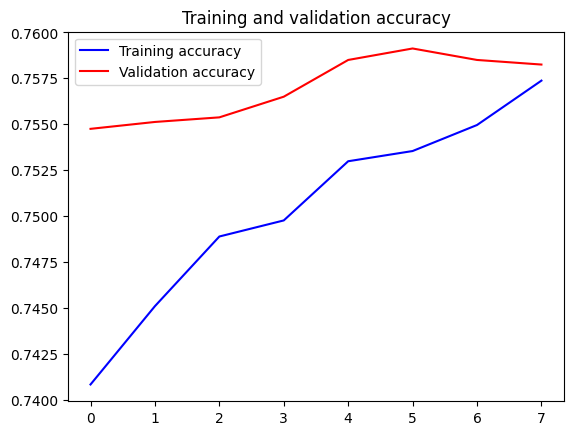

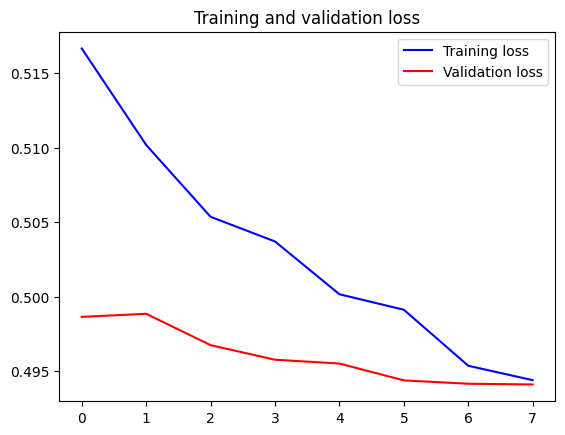

In [ ]:
acc = history.history.get('acc') or history.history.get('accuracy')
val_acc = history.history.get('val_acc') or history.history.get('val_accuracy')
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love sport")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


/var/folders/8b/_wrd0j755cj_xgf04tprxq000000gn/T/ipykernel_20522/1332943948.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


{'label': 'POSITIVE',
 'score': 0.9255228042602539,
 'elapsed_time': 0.10354804992675781}

In [ ]:
predict("I hate the rain")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/var/folders/8b/_wrd0j755cj_xgf04tprxq000000gn/T/ipykernel_20522/1332943948.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


{'label': 'NEGATIVE',
 'score': 0.0036303182132542133,
 'elapsed_time': 0.07733702659606934}

In [ ]:
predict("i don't know what i'm doing")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/var/folders/8b/_wrd0j755cj_xgf04tprxq000000gn/T/ipykernel_20522/1332943948.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


{'label': 'NEUTRAL',
 'score': 0.5445519089698792,
 'elapsed_time': 0.07122421264648438}